In [1]:
## Import libraries

import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
## Load data

taxi_zone_path = '../data/taxi+_zone_lookup.csv'
taxi_data_path = '../data/taxi_tripdata.csv'

taxi_zone_df = pd.read_csv(taxi_zone_path)
taxi_data_df = pd.read_csv(taxi_data_path)

# Clean data
taxi_data_df = taxi_data_df.drop(['ehail_fee'], axis = 1)
taxi_data_df = taxi_data_df.dropna()

## Remove trips 1 mile or less

dist_mask = taxi_data_df['trip_distance'] >= 1
taxi_data_df = taxi_data_df[dist_mask]
taxi_data_df.reset_index(drop=True, inplace=True)

## Remove fares which do not cost much

fare_mask = taxi_data_df['fare_amount'] >= 1
taxi_data_df = taxi_data_df[fare_mask]
taxi_data_df.reset_index(drop=True, inplace=True)

## Remove locations that are unknown

pu_mask = taxi_data_df['PULocationID'] <= 263
taxi_data_df = taxi_data_df[pu_mask]
taxi_data_df.reset_index(drop=True, inplace=True)

do_mask = taxi_data_df['DOLocationID'] <= 263
taxi_data_df = taxi_data_df[do_mask]
taxi_data_df.reset_index(drop=True, inplace=True)

print(len(taxi_data_df))

39587


/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
taxi_data_df[:20]

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
0,1.0,2021-07-01 00:30:52,2021-07-01 00:35:36,N,1.0,74,168,1.0,1.20,6.0,0.50,0.5,0.00,0.00,0.3,7.30,2.0,1.0,0.00
1,2.0,2021-07-01 00:41:40,2021-07-01 00:47:23,N,1.0,74,42,1.0,1.24,6.5,0.50,0.5,0.00,0.00,0.3,7.80,2.0,1.0,0.00
2,2.0,2021-07-01 00:51:32,2021-07-01 00:58:46,N,1.0,42,244,1.0,1.10,7.0,0.50,0.5,0.00,0.00,0.3,8.30,2.0,1.0,0.00
3,1.0,2021-07-01 00:05:00,2021-07-01 00:11:50,N,1.0,24,239,1.0,1.90,8.0,3.25,0.5,3.00,0.00,0.3,15.05,1.0,1.0,2.75
4,2.0,2021-07-01 00:29:09,2021-07-01 00:34:18,N,1.0,74,42,1.0,1.72,7.0,0.50,0.5,2.08,0.00,0.3,10.38,1.0,1.0,0.00
5,2.0,2021-07-01 00:41:33,2021-07-01 00:49:24,N,1.0,41,42,1.0,1.37,7.5,0.50,0.5,0.00,0.00,0.3,8.80,2.0,1.0,0.00
6,2.0,2021-07-01 00:31:14,2021-07-01 00:40:01,N,1.0,74,236,1.0,2.14,9.0,0.50,0.5,2.65,0.00,0.3,15.70,1.0,1.0,2.75
7,2.0,2021-06-07 15:15:47,2021-06-07 16:45:22,N,1.0,197,225,1.0,7.74,56.0,0.50,0.5,0.00,0.00,0.3,57.30,1.0,1.0,0.00
8,2.0,2021-07-01 00:31:21,2021-07-01 01:06:09,N,1.0,7,23,1.0,25.08,65.5,0.50,0.5,0.00,6.55,0.3,73.35,2.0,1.0,0.00
9,2.0,2021-07-01 00:12:53,2021-07-01 01:05:27,N,1.0,226,75,1.0,11.40,42.0,0.50,0.5,0.00,6.55,0.3,49.85,1.0,1.0,0.00


In [12]:
taxi_zone_df

,LocationID,Borough,Zone,service_zone
0,1,EWR,Newark Airport,EWR
1,2,Queens,Jamaica Bay,Boro Zone
2,3,Bronx,Allerton/Pelham Gardens,Boro Zone
3,4,Manhattan,Alphabet City,Yellow Zone
4,5,Staten Island,Arden Heights,Boro Zone
...,...,...,...,...
260,261,Manhattan,World Trade Center,Yellow Zone
261,262,Manhattan,Yorkville East,Yellow Zone
262,263,Manhattan,Yorkville West,Yellow Zone
263,264,Unknown,NV,NaN


In [4]:
## Create dictionary for graph nodes

#taxi_data_df = taxi_data_df[:50000]

taxi_dict= {}

contact_array = []
for i in range(len(taxi_zone_df)+1):
    contact_array.append([])
    
edge_weights = np.zeros((len(taxi_zone_df),len(taxi_zone_df)))

for i in range(len(taxi_data_df)):
    pu_id = taxi_data_df['PULocationID'][i]
    do_id = taxi_data_df['DOLocationID'][i]
    if pu_id != do_id:
        contact_array[pu_id].append(do_id)
        contact_array[do_id].append(pu_id)
    
for i,con in enumerate(contact_array):
    uniq_list = np.unique(con)
    taxi_dict[i] = uniq_list

## Delete insignificant keys (locations with little travel)

threshold = 50 ## !!! number of connections needed to be considered insignificant

delete_keys = []
for key in taxi_dict.keys():
    if len(taxi_dict[key]) <= threshold:
        delete_keys.append(key)
        
for key in delete_keys: 
    del taxi_dict[key]
    
for key in taxi_dict:
    for rem in delete_keys:
        taxi_dict[key] = np.delete(taxi_dict[key], np.where(taxi_dict[key] == rem))


In [5]:
## Create weights for edges

efficiency = 1/(taxi_data_df['fare_amount']/taxi_data_df['trip_distance'])
eff_total = np.zeros((len(taxi_zone_df)+1,len(taxi_zone_df)+1))
num_of_travel = np.ones((len(taxi_zone_df)+1,len(taxi_zone_df)+1))
weights = np.zeros((len(taxi_zone_df)+1,len(taxi_zone_df)+1))

for i in range(len(taxi_data_df)):
    pu_id = taxi_data_df['PULocationID'][i]
    do_id = taxi_data_df['DOLocationID'][i]
    sites = (pu_id,do_id)
    for key in taxi_dict.keys():
        if (pu_id == key) & (do_id in taxi_dict[key]):
            eff_total[pu_id][do_id] += efficiency[i]
            num_of_travel[pu_id][do_id] += 1
            eff_total[do_id][pu_id] += efficiency[i]
            num_of_travel[do_id][pu_id] += 1
        
for i in range(eff_total.shape[0]):
    for j in range(eff_total.shape[1]):
        if eff_total[i,j] != 0:
            weights[i,j] = 1/(eff_total[i,j]/num_of_travel[i,j])

taxi_graph = nx.Graph(taxi_dict)

In [6]:
## Apply weights to graph

for key in taxi_dict.keys():
    for connection in taxi_dict[key]:
        taxi_graph[key][connection]['weight'] = weights[key][connection]

In [7]:
## Applying names to graph

for key in taxi_dict.keys():
    taxi_graph.nodes[key]['name'] = taxi_zone_df['Borough'][key-1]

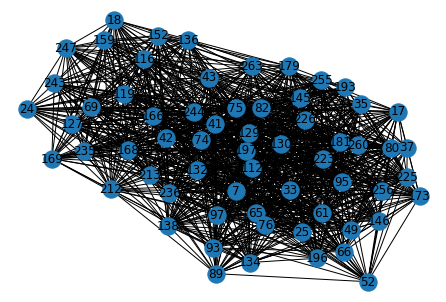

In [8]:
nx.draw(taxi_graph, with_labels=True)

In [15]:
## Checking values of weights
## Higher weights mean more traffic

# Get the edges and weights as a list of tuples
edges_and_weights = [(u, v, data.get('weight', 1)) for u, v, data in taxi_graph.edges(data=True)]

# Sort the list based on weights in descending order
sorted_edges = sorted(edges_and_weights, key=lambda x: x[2], reverse=True)

# Print the sorted list
for u, v, weight in sorted_edges:
    print(f"Edge ({u}, {v}) has weight: {weight}")

Edge (93, 138) has weight: 23.4375
Edge (132, 197) has weight: 19.734345351043643
Edge (37, 197) has weight: 19.27927927927928
Edge (35, 41) has weight: 13.952282157676347
Edge (223, 256) has weight: 13.086642599277976
Edge (66, 130) has weight: 12.810248198558849
Edge (35, 80) has weight: 12.158808933002481
Edge (69, 236) has weight: 11.904761904761907
Edge (93, 213) has weight: 11.687306501547988
Edge (193, 197) has weight: 11.535048802129548
Edge (7, 66) has weight: 11.501316944688323
Edge (193, 255) has weight: 11.492281303602057
Edge (49, 130) has weight: 11.417697431018079
Edge (17, 197) has weight: 11.085180863477246
Edge (119, 169) has weight: 10.915246123070084
Edge (17, 112) has weight: 10.882352941176471
Edge (33, 76) has weight: 10.847457627118644
Edge (7, 168) has weight: 10.704960835509139
Edge (76, 93) has weight: 10.626992561105206
Edge (17, 173) has weight: 10.624169986719787
Edge (82, 159) has weight: 10.39755351681957
Edge (146, 256) has weight: 10.393873085339168
Ed

In [16]:
for node in taxi_graph.nodes(data=True):
    node_id = node[0]
    name = node[1].get('name', 'No name')
    zone = taxi_zone_df.loc[node_id - 1, 'Zone']  # Adjusting for 0-based indexing

    print(f"Node ID: {node_id}, Name: {name}, Zone: {zone}")

Node ID: 7, Name: Queens, Zone: Astoria
Node ID: 17, Name: Brooklyn, Zone: Bedford
Node ID: 18, Name: Bronx, Zone: Bedford Park
Node ID: 24, Name: Manhattan, Zone: Bloomingdale
Node ID: 25, Name: Brooklyn, Zone: Boerum Hill
Node ID: 33, Name: Brooklyn, Zone: Brooklyn Heights
Node ID: 35, Name: Brooklyn, Zone: Brownsville
Node ID: 37, Name: Brooklyn, Zone: Bushwick South
Node ID: 41, Name: Manhattan, Zone: Central Harlem
Node ID: 42, Name: Manhattan, Zone: Central Harlem North
Node ID: 43, Name: Manhattan, Zone: Central Park
Node ID: 49, Name: Brooklyn, Zone: Clinton Hill
Node ID: 52, Name: Brooklyn, Zone: Cobble Hill
Node ID: 61, Name: Brooklyn, Zone: Crown Heights North
Node ID: 65, Name: Brooklyn, Zone: Downtown Brooklyn/MetroTech
Node ID: 66, Name: Brooklyn, Zone: DUMBO/Vinegar Hill
Node ID: 69, Name: Bronx, Zone: East Concourse/Concourse Village
Node ID: 74, Name: Manhattan, Zone: East Harlem North
Node ID: 75, Name: Manhattan, Zone: East Harlem South
Node ID: 76, Name: Brooklyn, Z

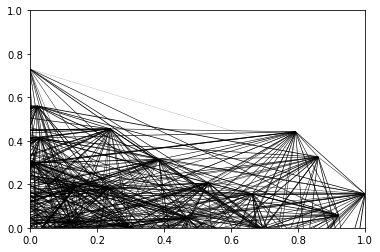

In [11]:
## Drawing graph but with edge width matching weight size

edge_weights = nx.get_edge_attributes(taxi_graph, 'weight')
pos = nx.spring_layout(taxi_graph) 
for (u, v), weight in edge_weights.items():
    nx.draw_networkx_edges(taxi_graph,pos, edgelist=[(u, v)], width=weight/10)

plt.show()

# Comments

Critical questions to answer:

How many connections is enough (threshold in cell 66)?

How large should our dataset be (Dataset contains 40,000 fares)?

What other variables to include from the dataset (such as congestion)?